### 1. SQL

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [ ]:
path = ""
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]

In [ ]:

con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.31it/s]


In [ ]:
df=pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)
df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4-12-0-0,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4-13-0-0,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4-14-0-0,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4-15-0-0,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4-16-0-0,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [ ]:
#listing all the tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')

Total of 8 tables in database.


In [ ]:
#checking the data size
fitbit_df = pd.read_sql(f'SELECT * FROM fitbit_df', con)
print(len(fitbit_df))
fitbit_df.head()

826


,SedentaryMinutes,TotalSteps,TotalMinutesAsleep,TotalTimeInBed,Calories
0,728,13162,327,346,1985
1,776,10735,384,407,1797
2,726,9762,412,442,1745
3,773,12669,340,367,1863
4,539,9705,700,712,1728


### 1. Perform exploratory analysis

In [ ]:
# Average Calories, Steps and Distance by Id and by day of the week
query = """
SELECT
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalMinutesAsleep),2) AS avg_minutesAsleep
FROM fitbit_df
GROUP BY TotalTimeInBed;
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

,avg_calories,avg_steps,avg_minutesAsleep
0,2225.0,5600.0,58.0
1,2402.5,6960.0,60.5
2,1804.0,5079.0,61.0
3,3331.0,19769.0,74.0
4,3051.0,1982.0,77.0


In [ ]:
#join fitbit data and sleep data
join_query = """
SELECT
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM
	fitbit_df A
INNER JOIN sleepDay_merged S
ON
    A.TotalTimeInBed=S.TotalTimeInBed;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df.head()

,SedentaryMinutes,TotalMinutesAsleep
0,728,319
1,728,319
2,728,319
3,728,319
4,728,319


<AxesSubplot:xlabel='TotalTimeInBed', ylabel='Calories'>

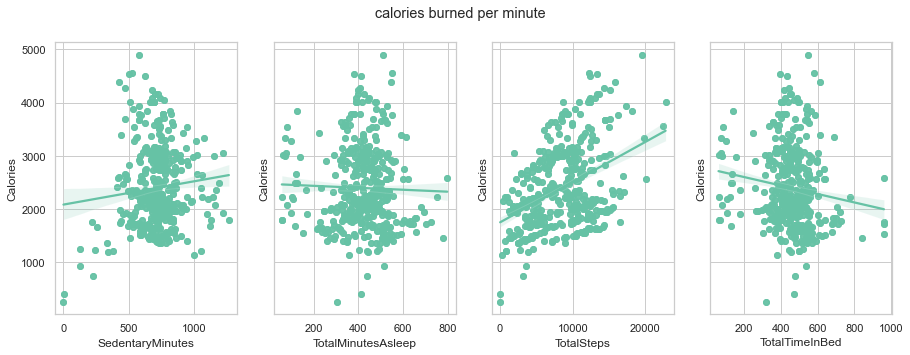

In [ ]:
#a)Initial Exploratory Visualizations
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('calories burned per minute')

sns.regplot(data = fitbit_df, x = 'SedentaryMinutes', y = 'Calories', ax=axes[0])

sns.regplot(data = fitbit_df, x = 'TotalMinutesAsleep', y = 'Calories', ax=axes[1])

sns.regplot(data = fitbit_df, x = 'TotalSteps', y = 'Calories', ax=axes[2])

sns.regplot(data = fitbit_df, x = 'TotalTimeInBed', y = 'Calories', ax=axes[3])

Index(['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'Calories'],
      dtype='object')


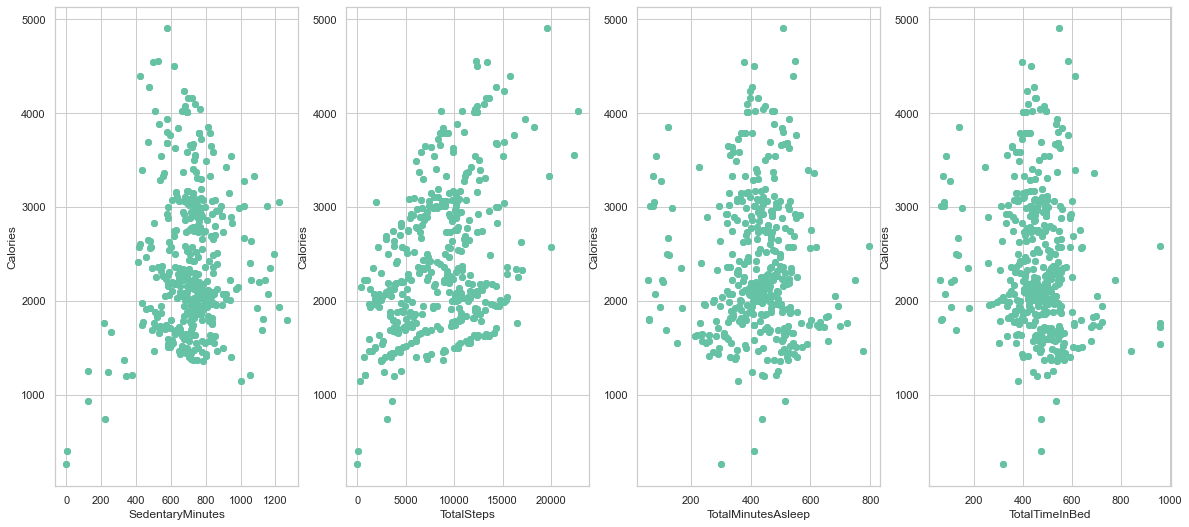

In [ ]:
#correlation measures
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

#Define a function to plot the scatterplots of the relationships between
#all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    variables = df.columns

    #assume that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    #Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

<AxesSubplot:>

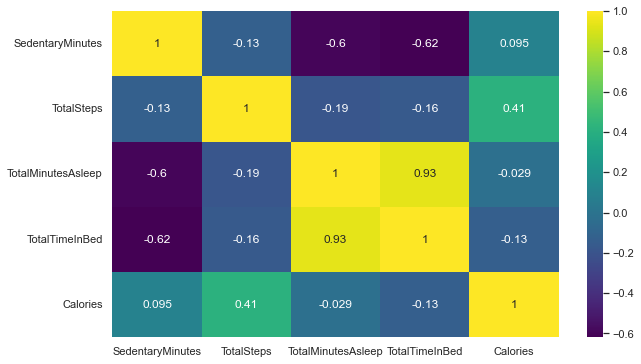

In [ ]:
#Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='viridis', fmt='.2g')

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1],
                                                              fitbit_df['Calories'],
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp,
                                                      test_size=0.25, random_state=42)

In [ ]:
#scale the data with object range of 0-1
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.59762846, 0.67969059, 0.40514905, 0.38777778],
       [0.66482213, 0.09031776, 0.51626016, 0.44555556],
       [0.55731225, 0.44442491, 0.52439024, 0.47555556],
       [0.66403162, 0.12938953, 0.42276423, 0.38333333],
       [0.54703557, 0.43176724, 0.41056911, 0.34555556],
       [0.10039526, 0.15690239, 0.62059621, 0.52666667],
       [0.63715415, 0.05726717, 0.64092141, 0.54555556],
       [0.4743083 , 0.45699468, 0.43766938, 0.56111111],
       [0.53754941, 0.47303652, 0.30894309, 0.27333333],
       [0.68221344, 0.22612403, 0.49457995, 0.42222222],
       [0.43162055, 0.21614732, 0.85907859, 0.73444444],
       [0.49249012, 0.43405265, 0.63550136, 0.54666667],
       [0.53754941, 0.34536105, 0.51897019, 0.46222222],
       [0.17233202, 0.17566914, 0.899729  , 1.        ],
       [0.54703557, 0.54445568, 0.44715447, 0.37888889],
       [0.49644269, 0.21575177, 0.54878049, 0.47222222],
       [0.51620553, 0.14582692, 0.6598916 , 0.56333333],
       [0.60474308, 0.26770096,

In [ ]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

#Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

#Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 607.8242.
Mean Squared Error: 598008.6000.
R^2 Score = -0.0331.
Accuracy = 67.95%.


Text(0, 0.5, 'Coefficients')

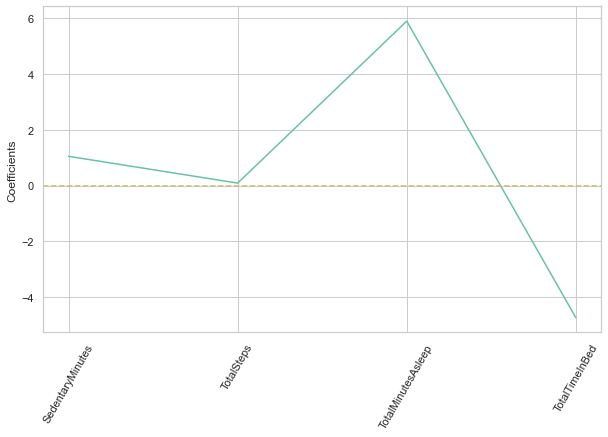

In [ ]:

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='y')
plt.ylabel('Coefficients')

In [ ]:
#b)tree machine learning models RandomForest classifier
rf_regressor = rf_sk(random_state=42)
rf = rf_regressor.fit(X_train, y_train)
scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 298.2638.
Mean Squared Error: 176096.9115.
R^2 Score = 0.6958.
Accuracy = 86.02%.


In [ ]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_classifier=DecisionTreeClassifier()

In [ ]:
model=dt_classifier.fit(X_train,y_train)

In [ ]:
scoring(model,X_valid,y_valid)

Model Performance
Mean Absolute Error: 280.5394.
Mean Squared Error: 350200.0909.
R^2 Score = 0.3950.
Accuracy = 87.38%.


#### By comparing the two tree models which is Rrandom forest and DecisionTree Classifier, the random forest model performs better with 77.49 % accuracy with high R^2 value

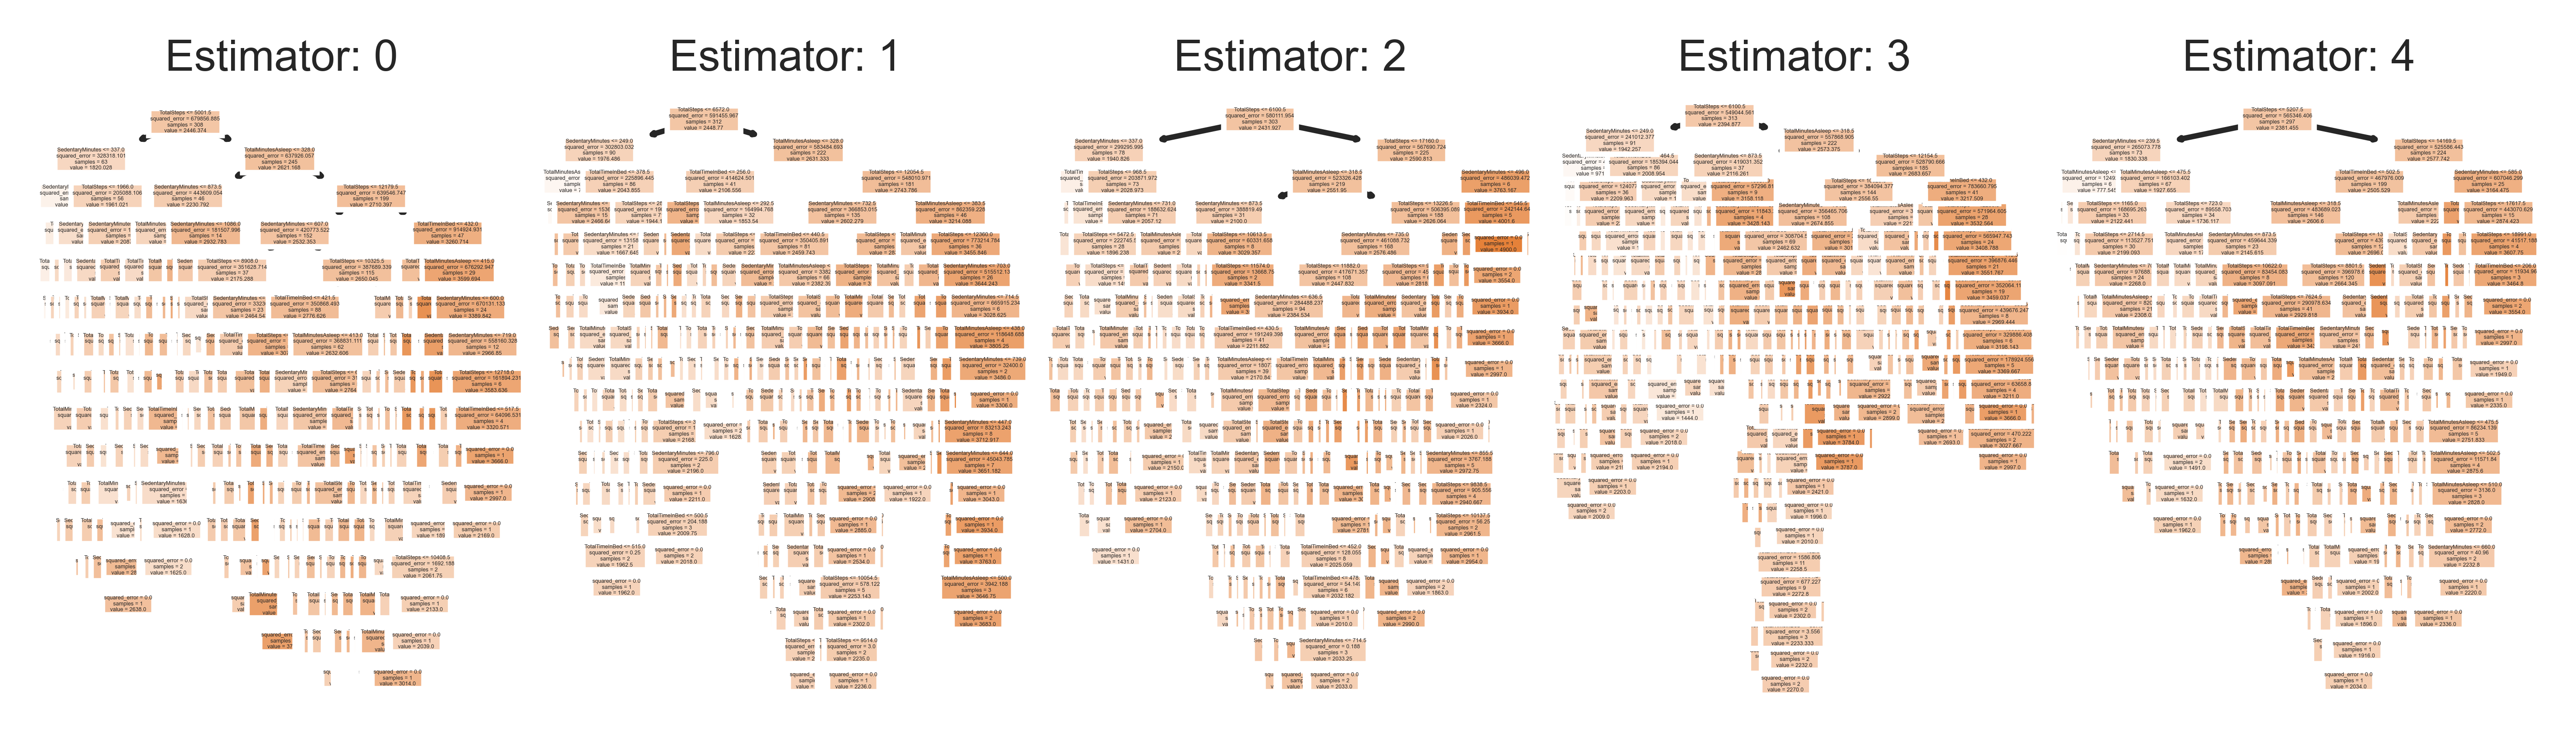

In [ ]:
#let's take a look at the first 5 estimators in the Random Forest
fn=['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
cn=['Calories']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (8,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 8)

In [ ]:
#c)Choose the best performing model from Q.2b to implement a scalable workflow
#using PySpark and report your observations.
fitbit_df.to_csv('fitbit_df.csv', index=False)

CSV_PATH = "./fitbit_df.csv"
APP_NAME = "Random Forest"
SPARK_URL = "local[*]"
RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

print("Total number of rows: %d" % df.count())

df.printSchema()

df.show()

Total number of rows: 826
root
 |-- SedentaryMinutes: integer (nullable = true)
 |-- TotalSteps: integer (nullable = true)
 |-- TotalMinutesAsleep: integer (nullable = true)
 |-- TotalTimeInBed: integer (nullable = true)
 |-- Calories: integer (nullable = true)

+----------------+----------+------------------+--------------+--------+
|SedentaryMinutes|TotalSteps|TotalMinutesAsleep|TotalTimeInBed|Calories|
+----------------+----------+------------------+--------------+--------+
|             728|     13162|               327|           346|    1985|
|             776|     10735|               384|           407|    1797|
|             726|      9762|               412|           442|    1745|
|             773|     12669|               340|           367|    1863|
|             539|      9705|               700|           712|    1728|
|             775|     15506|               304|           320|    2035|
|             818|     10544|               360|           377|    1786|
|      

In [ ]:
#create features
featureCols = ['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)
spark_df = df.select(['features', 'Calories'])

spark_df.show()
spark_df.printSchema()

+--------------------+--------+
|            features|Calories|
+--------------------+--------+
|[728.0,13162.0,32...|    1985|
|[776.0,10735.0,38...|    1797|
|[726.0,9762.0,412...|    1745|
|[773.0,12669.0,34...|    1863|
|[539.0,9705.0,700...|    1728|
|[775.0,15506.0,30...|    2035|
|[818.0,10544.0,36...|    1786|
|[838.0,9819.0,325...|    1775|
|[732.0,14371.0,36...|    1949|
|[709.0,10039.0,43...|    1788|
|[814.0,15355.0,27...|    2013|
|[833.0,13755.0,24...|    1970|
|[782.0,13154.0,36...|    1898|
|[815.0,11181.0,34...|    1837|
|[712.0,14673.0,40...|    1947|
|[730.0,10602.0,36...|    1820|
|[798.0,14727.0,27...|    2004|
|[816.0,15103.0,27...|    1990|
|[857.0,14070.0,24...|    1959|
|[754.0,12159.0,33...|    1896|
+--------------------+--------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- Calories: integer (nullable = true)



In [ ]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 42)
print("Number of training set rows: %d" % train.count())
print("Number of test set rows: %d" % test.count())

Number of training set rows: 694
Number of test set rows: 132


In [ ]:
rf=rf_sp(featuresCol="features", labelCol='Calories')
model = rf.fit(train)
predictions = model.transform(test)
predictions.select("prediction", "Calories", "features").show(5)
preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']
errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')

+------------------+--------+--------------------+
|        prediction|Calories|            features|
+------------------+--------+--------------------+
| 746.5469841269841|     403|[2.0,42.0,411.0,4...|
|1277.5262979526933|     928|[127.0,3587.0,516...|
|1971.5321269008768|    1763|[218.0,4014.0,722...|
|1113.0019720154398|    1240|[241.0,2752.0,404...|
|1414.7566300366302|    1199|[343.0,3789.0,444...|
+------------------+--------+--------------------+
only showing top 5 rows

Accuracy = 79.0412 %


###### Using the pyspark

In [ ]:

regressor = LinearRegression()
mlr = regressor.fit(X_train, y_train)
scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 495.5877.
Mean Squared Error: 381000.5655.
R^2 Score = 0.3418.
Accuracy = 76.63%.


In [ ]:
from pyspark.ml.regression import LinearRegression as lr
mlr = lr(featuresCol="features", labelCol='Calories')

model = mlr.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "Calories", "features").show(5)

preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']

errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')

+------------------+--------+--------------------+
|        prediction|Calories|            features|
+------------------+--------+--------------------+
| 712.1685613713628|     403|[2.0,42.0,411.0,4...|
|1493.9896941061868|     928|[127.0,3587.0,516...|
| 994.3133340153852|    1763|[218.0,4014.0,722...|
|1321.9084743402102|    1240|[241.0,2752.0,404...|
|1687.1243483592743|    1199|[343.0,3789.0,444...|
+------------------+--------+--------------------+
only showing top 5 rows

Accuracy = 75.3858 %


2.
install.packages("datarium")
install.packages("Hmisc")
library(datarium)
library(Hmisc)
library(dplyr)
library(ggplot2)
data("marketing",package="datarium")
marketing
#Relationship
marketing %>% ggplot(aes(x=youtube,y=sales))+geom_point()+labs(x="spendings on  youtube",y="sales",title="Graph:1")+ stat_smooth(se=FALSE)
marketing %>% ggplot(aes(x=facebook,y=sales))+geom_point()+labs(x="spendings on  facebook",y="sales",title="Graph:2")+ stat_smooth(se=FALSE)
marketing %>% ggplot(aes(x=newspaper,y=sales))+geom_point()+labs(x="spendings on  newspaper",y="sales",title="Graph:3")+ stat_smooth(se=FALSE)
#LInear Relationship
cor(marketing$youtube,marketing$sales)
cor(marketing$facebook,marketing$sales)
cor(marketing$newspaper,marketing$sales)

#medium Contribution to sales
lm_sales<-lm(sales~youtube+facebook+newspaper,data = marketing)
summary(lm_sales)

#effect
coefficients(lm_sales)

#synergy
lm_sales_interaction<-lm(sales~(youtube+facebook+newspaper)^2,data = marketing)
summary(lm_sales_interaction)

#prediction
investment<- c(1000,2000,1500)
predicted_sales<-predict(lm_sales,newdata=data.frame(youtube=investment[1],facebook=investment[2],newspaper=investment[3]))
predicted_sales

sum_investment<-sum(investment)
predicted_sales<-predict(lm_sales,newdata=data.frame(youtube=sum_investment,facebook=sum_investment,newspaper=sum_investment))
predicted_sales

#ml Visualization
marketing %>% ggplot(aes(x=youtube,y=sales))+geom_point()+labs(x="spendings on  youtube",y="sales",title="Graph:1")+ geom_smooth(method="lm",se=FALSE)
marketing %>% ggplot(aes(x=facebook,y=sales))+geom_point()+labs(x="spendings on facebook ",y="sales",title="Graph:2")+ geom_smooth(method="lm",se=FALSE)
marketing %>% ggplot(aes(x=newspaper,y=sales))+geom_point()+labs(x="spendings on newspaper ",y="sales",title="Graph:3")+ geom_smooth(method="lm",se=FALSE)

### 3. A data scientist has to build an Artificial Neural Network (ANN) model

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

In [ ]:
df=pd.read_csv("C:\\Users\\Asus\\OneDrive\\Desktop\\Predictive Analayis\\Telecom Customer Management.csv")

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
#Converting Total Charges to a numerical data type.
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
#Removing missing values
df.dropna(inplace = True)

#Remove customer IDs from the data set
df=df.iloc[:,1:]

In [ ]:
#Converting the predictor variable in a binary numeric variable
df['Churn'].replace('Yes',1,inplace=True)
df['Churn'].replace('No',0,inplace=True)

In [ ]:
df['gender'].value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

In [ ]:
df['gender'].replace('Male',1,inplace=True)
df['gender'].replace('Female',2,inplace=True)

In [ ]:
df['Partner'].value_counts()

No     3639
Yes    3393
Name: Partner, dtype: int64

In [ ]:
df['SeniorCitizen'].value_counts()

0    5890
1    1142
Name: SeniorCitizen, dtype: int64

In [ ]:
df['Partner'].replace('Yes',1,inplace=True)
df['Partner'].replace('No',0,inplace=True)

In [ ]:
df['PhoneService'].value_counts()

Yes    6352
No      680
Name: PhoneService, dtype: int64

In [ ]:
df['PhoneService'].replace('Yes',1,inplace=True)
df['PhoneService'].replace('No',0,inplace=True)

In [ ]:
df['Dependents'].value_counts()

No     4933
Yes    2099
Name: Dependents, dtype: int64

In [ ]:
df['Dependents'].replace('Yes',1,inplace=True)
df['Dependents'].replace('No',0,inplace=True)

In [ ]:
df['MultipleLines'].value_counts()

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

In [ ]:
df['MultipleLines'].replace('Yes',1,inplace=True)
df['MultipleLines'].replace('No',0,inplace=True)
df['MultipleLines'].replace('No phone service',2,inplace=True)

In [ ]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [ ]:
df['InternetService'].replace('Fiber optic',1,inplace=True)
df['InternetService'].replace('DSL',2,inplace=True)
df['InternetService'].replace('No',0,inplace=True)

In [ ]:
df['OnlineSecurity'].value_counts()

No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64

In [ ]:
df['OnlineSecurity'].replace('No',0,inplace=True)
df['OnlineSecurity'].replace('Yes',1,inplace=True)
df['OnlineSecurity'].replace('No internet service',2,inplace=True)

In [ ]:
df['OnlineBackup'].value_counts()

No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64

In [ ]:
df['OnlineBackup'].replace('No',0,inplace=True)
df['OnlineBackup'].replace('Yes',1,inplace=True)
df['OnlineBackup'].replace('No internet service',2,inplace=True)

In [ ]:
df['DeviceProtection'].value_counts()

No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64

In [ ]:
df['DeviceProtection'].replace('No',0,inplace=True)
df['DeviceProtection'].replace('Yes',1,inplace=True)
df['DeviceProtection'].replace('No internet service',2,inplace=True)

In [ ]:
df['TechSupport'].value_counts()

No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64

In [ ]:
df['TechSupport'].replace('No',0,inplace=True)
df['TechSupport'].replace('Yes',1,inplace=True)
df['TechSupport'].replace('No internet service',2,inplace=True)

In [ ]:
df['StreamingTV'].value_counts()

No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64

In [ ]:
df['StreamingTV'].replace('No',0,inplace=True)
df['StreamingTV'].replace('Yes',1,inplace=True)
df['StreamingTV'].replace('No internet service',2,inplace=True)

In [ ]:
df['StreamingMovies'].value_counts()

No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64

In [ ]:
df['StreamingMovies'].replace('No',0,inplace=True)
df['StreamingMovies'].replace('Yes',1,inplace=True)
df['StreamingMovies'].replace('No internet service',2,inplace=True)

In [ ]:
df['Contract'].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

In [ ]:
df['Contract'].replace('Month-to-month',1,inplace=True)
df['Contract'].replace('Two year',2,inplace=True)
df['Contract'].replace('One year',3,inplace=True)

In [ ]:
df['PaperlessBilling'].value_counts()

Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64

In [ ]:
df['PaperlessBilling'].replace('Yes',1,inplace=True)
df['PaperlessBilling'].replace('No',0,inplace=True)

In [ ]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

In [ ]:
df['PaymentMethod'].replace('Electronic check',1,inplace=True)
df['PaymentMethod'].replace('Mailed check',2,inplace=True)
df['PaymentMethod'].replace('Bank transfer (automatic)',3,inplace=True)
df['PaymentMethod'].replace('Credit card (automatic)',4,inplace=True)

In [ ]:
X=df.drop(columns = ['Churn'])
Y=df['Churn'].values

In [ ]:
#Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [ ]:
X_test.shape

(2110, 19)

In [ ]:
Y_test.shape

(2110,)

In [ ]:
learning_rate=0.001
ensemble=3
frac=0.7

predictions_total = np.zeros(2110,dtype=int)
for i in range(ensemble):
    print("numberof iteration:",i)
    print("prediction_total",predictions_total)

    #samples randomly the train data

    X_train
    Y_train

    model = tf.keras.models.Sequential()
    #adding the input layer and first hidden layer
    model.add(tf.keras.layers.Dense(units=36,kernel_initializer='normal',activation='relu',input_dim=19))

    #Add second hidden layer
    model.add(tf.keras.layers.Dense(units=24,kernel_initializer='normal',activation='relu'))


    #Add output layer
    model.add(tf.keras.layers.Dense(units=1,kernel_initializer='normal',activation='sigmoid'))

    #compiling the ANN
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0)
    model.compile(loss='mse',optimizer=adam,metrics=['mean_squared_error'])

    model.fit(X_train,Y_train,batch_size=34,epochs=100)

    model_predictions=model.predict(X_test)
    model_predictions=model_predictions.flatten()

    print("TEST MSE for induvidual Models",mean_squared_error(Y_test,model_predictions))
    print("")
    print(model_predictions)
    print("")
    predictions_total = np.add(predictions_total,model_predictions)

numberof iteration: 0
prediction_total [0 0 0 ... 0 0 0]
Epoch 1/100
145/145 [==============================] - 1s 3ms/step - loss: 0.2227 - mean_squared_error: 0.2227
Epoch 2/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1772 - mean_squared_error: 0.1772
Epoch 3/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1591 - mean_squared_error: 0.1591
Epoch 4/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1589 - mean_squared_error: 0.1589
Epoch 5/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1628 - mean_squared_error: 0.1628
Epoch 6/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1780 - mean_squared_error: 0.1780
Epoch 7/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1598 - mean_squared_error: 0.1598
Epoch 8/100
145/145 [==============================] - 0s 3ms/step - loss: 0.1617 - mean_squared_error: 0.1617
Epoch 9/100
145/145 [==============================] - 

In [ ]:
print("")
#Average of predictions - Ensemble by averaging the values
predictions_total = predictions_total/ensemble
print("MSE after ensemble:",mean_squared_error(np.array(Y_test),predictions_total))
print("")
print(predictions_total)


MSE after ensemble: 0.13710921870358778

[0.38827232 0.14753578 0.24220489 ... 0.22017299 0.00202804 0.18712347]


In [ ]:
#predict if the customer with information shown in Table.2 will churn the telecom service:
print(model.predict([[1,0,1,0,2,0,2,2,1,0,0,1,0,0,1,1,1,39.5,59.85]])>0.5)

1/1 [==============================] - 0s 137ms/step
[[ True]]
